In [2]:
%pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/99/a1/5219921a9bcb5388623f81908ff43d606aec2e512e0c02f6eb49f3b3caa8/xgboost-2.1.1-py3-none-macosx_12_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 2.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [4]:
pjme = pd.read_csv('datasets/PJME_hourly.csv', index_col=[0], parse_dates=[0])


In [5]:
pjme.head(50)

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
2002-12-31 06:00:00,26222.0
2002-12-31 07:00:00,28702.0
2002-12-31 08:00:00,30698.0
2002-12-31 09:00:00,31800.0


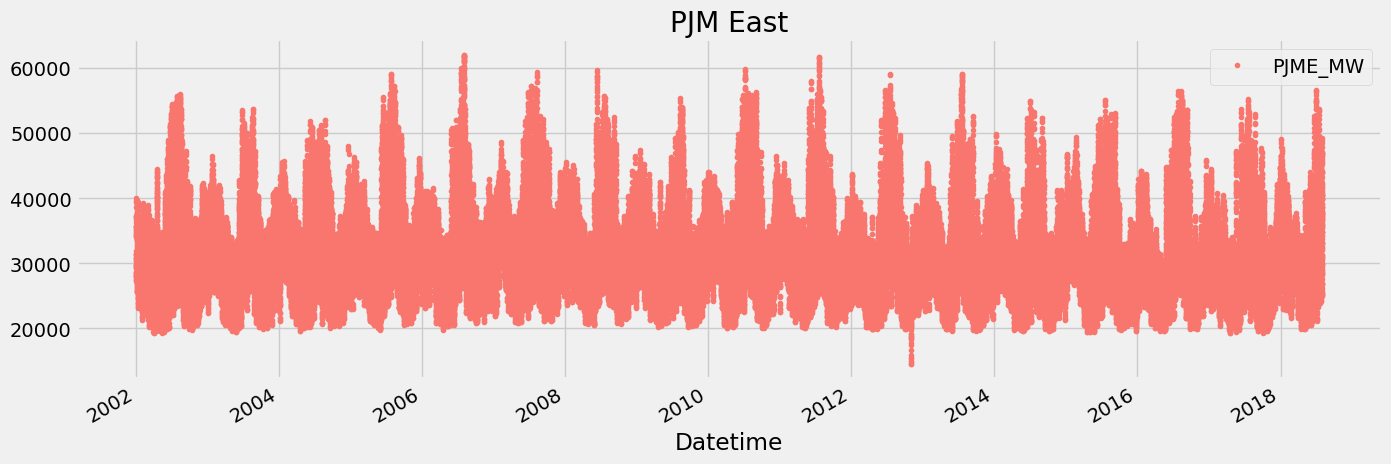

In [6]:
# distribuicão de consumo de energia

color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

In [7]:
# divisão de treino/teste
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

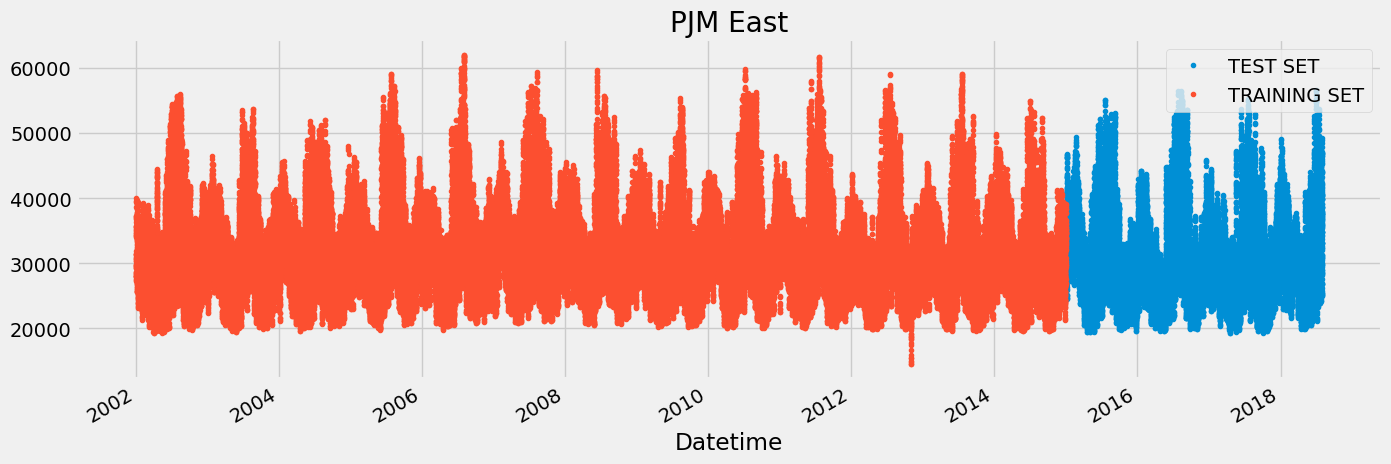

In [8]:
_ = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

In [15]:
# definir os atributos que serão inputados no algoritmo
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [16]:
X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')

In [18]:
# É AQUI QUE A BRINCADEIRA COMEÇA | Criação do modelo XGBoost
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=True)

[0]	validation_0-rmse:5178.20659	validation_1-rmse:5362.58699
[1]	validation_0-rmse:4381.36190	validation_1-rmse:4701.24012
[2]	validation_0-rmse:3875.94540	validation_1-rmse:4291.42311
[3]	validation_0-rmse:3568.61653	validation_1-rmse:4100.19117
[4]	validation_0-rmse:3386.60370	validation_1-rmse:3984.47407
[5]	validation_0-rmse:3235.37054	validation_1-rmse:3900.92655
[6]	validation_0-rmse:3139.99310	validation_1-rmse:3880.43917
[7]	validation_0-rmse:3050.64640	validation_1-rmse:3810.32224
[8]	validation_0-rmse:3008.72051	validation_1-rmse:3777.52114
[9]	validation_0-rmse:2949.06175	validation_1-rmse:3756.20242
[10]	validation_0-rmse:2919.69527	validation_1-rmse:3749.04384
[11]	validation_0-rmse:2837.28993	validation_1-rmse:3772.71643
[12]	validation_0-rmse:2803.01698	validation_1-rmse:3807.39750
[13]	validation_0-rmse:2740.07411	validation_1-rmse:3841.05399
[14]	validation_0-rmse:2708.28013	validation_1-rmse:3873.14074
[15]	validation_0-rmse:2678.86325	validation_1-rmse:3922.42404
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

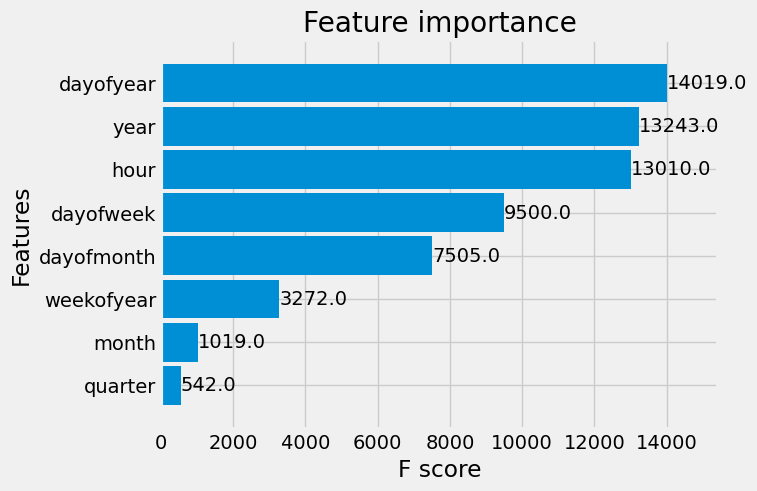

In [19]:
# plota a importancia dos atributos
_ = plot_importance(reg, height=0.9)

In [20]:
# realiza a previsão
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

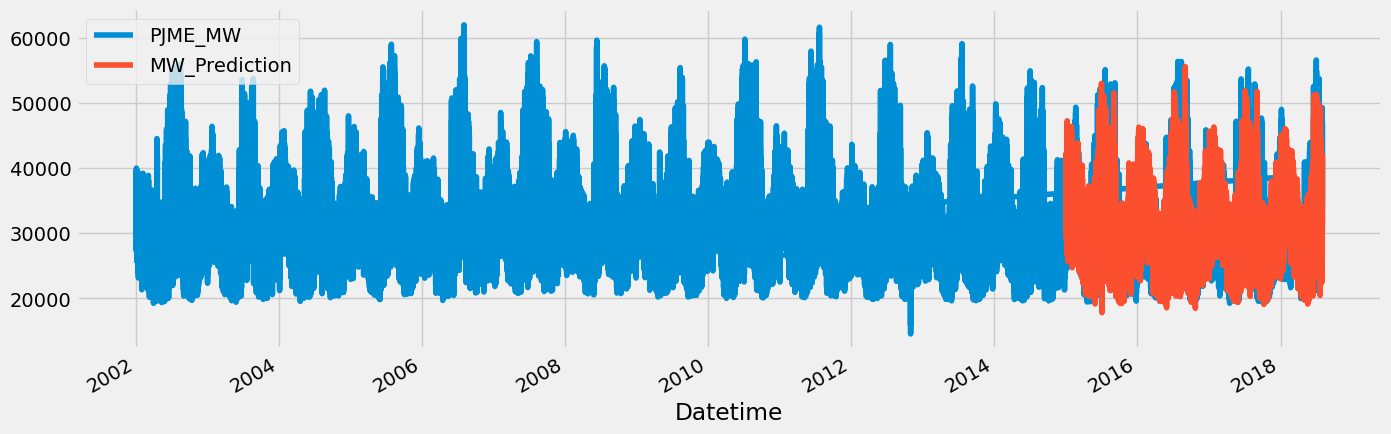

In [21]:
_ = pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

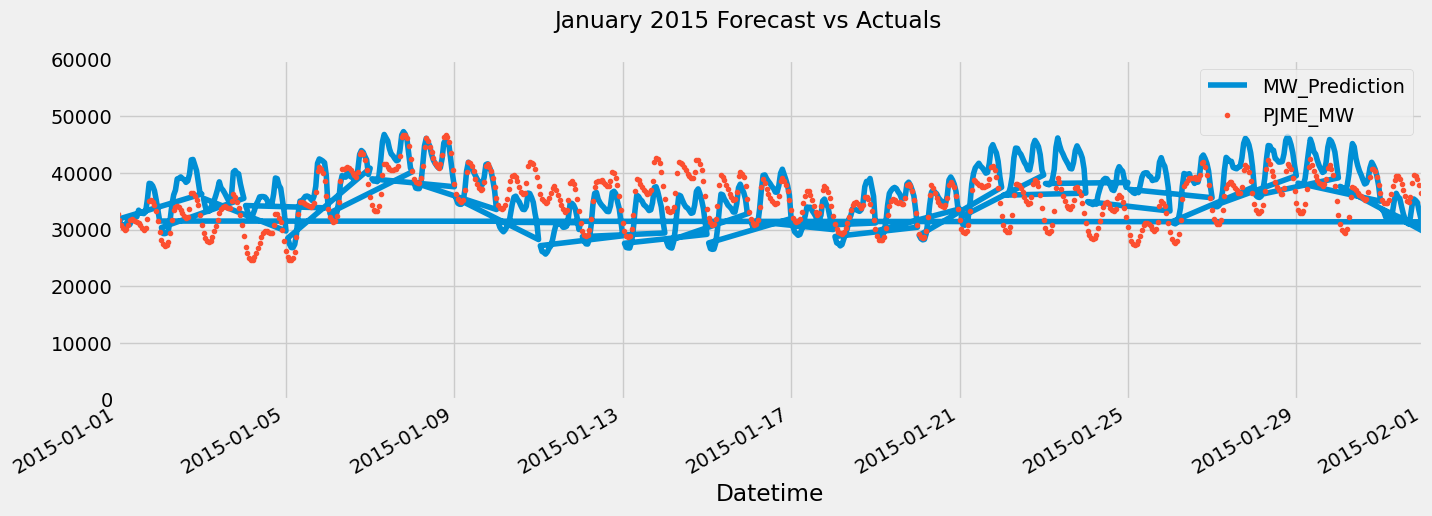

In [22]:
# visão mensal
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

In [23]:
# RMSE
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

19254716.0103453

In [24]:
# MAE
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

3273.267225134884

In [25]:
# MAE Percentual

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])


10.220159391408068

In [27]:
# mostrar as melhores e piores previsões

pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error']]

In [29]:
# Piores previsões
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJME_MW  MW_Prediction         error     abs_error
year month dayofmonth                                                         
2016 8     13          45185.833333   27478.736328  17707.097005  17707.097005
2017 9     2           24201.458333   41096.625000 -16895.165934  16895.165934
2016 8     14          44427.333333   27881.398438  16545.934814  16545.934814
           12          45724.708333   30696.572266  15028.136312  15028.136312
2017 9     1           27280.500000   39896.550781 -12616.052083  12616.052083
2016 8     15          43938.875000   31370.429688  12568.446615  12568.446615
2015 2     21          40918.666667   28580.751953  12337.913737  12337.913737
           20          44694.041667   32379.783203  12314.257650  12314.257650
2017 9     3           24385.625000   36007.949219 -11622.322998  11622.322998
     5     19          38032.583333   26463.150391  11569.432617  11569.432617

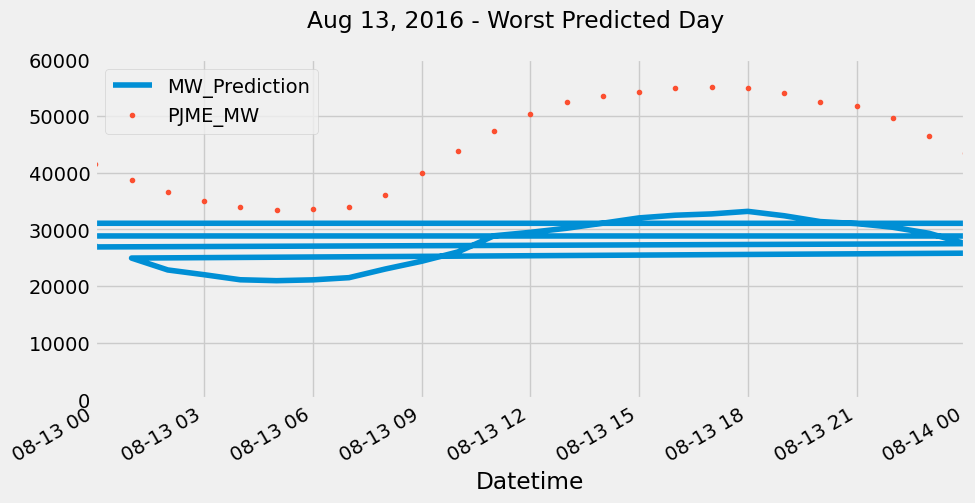

In [34]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

In [30]:
# melhores previsões
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2015 10    24          24779.416667   24783.789062   -4.372233  175.729655
           7           27375.041667   27531.257812 -156.216227  210.426025
2016 10    7           27065.958333   26980.656250   85.302653  253.716878
     5     5           27239.875000   27219.166016   20.707438  262.407633
2015 6     6           26893.333333   26891.304688    2.028076  265.797607
2016 4     29          27014.291667   27201.505859 -187.212646  273.001383
2015 9     22          28185.875000   28446.898438 -261.022868  284.742106
2016 5     12          26955.833333   27130.291016 -174.458984  298.652669
     11    12          26472.791667   26406.921875   65.871012  302.870524
     10    24          26255.000000   26376.658203 -121.657715  306.829590

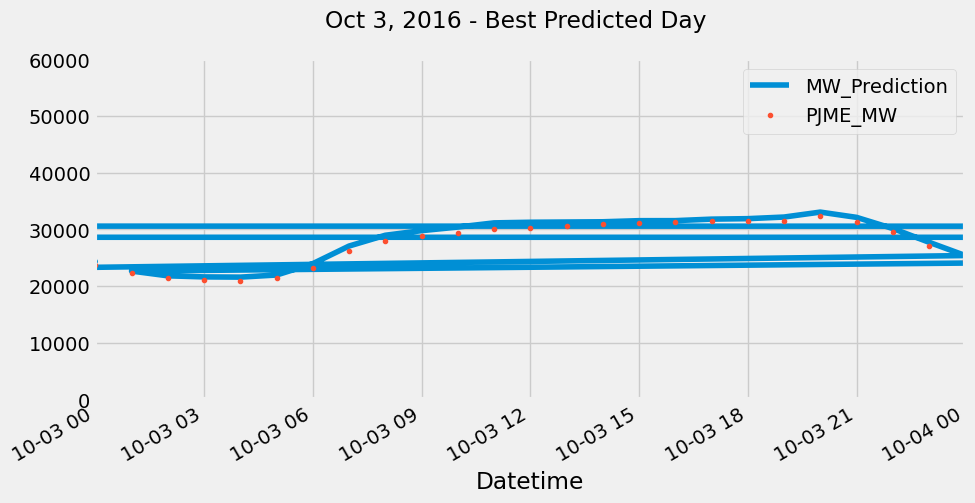

In [35]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')